# Explore `meta-kaggle` Dataset

## --- Test Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [19]:
# std library
from pprint import pprint
from datetime import datetime, timedelta

# third-party
from matplotlib import pyplot as plt
import numpy as np
from numpy import typing as npt

# local
import ryvkin_model
import nhpp

### 1. Model Setting

In [20]:
# Capacities & Total Innovation Uncertainty
## Hour based
param_c_i = 1.5
param_c_j = 1.5
param_sigma = 1.0

# Contest related
param_theta = 2.0

# Signal Precision
param_lambda = 0.1

# Contest Time Duaration
time_step = 1 / 12
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=np.datetime64)

print(contest_days, contest_hours, len(contest_timegrids))

90 2160 2160


### 2. Simulations

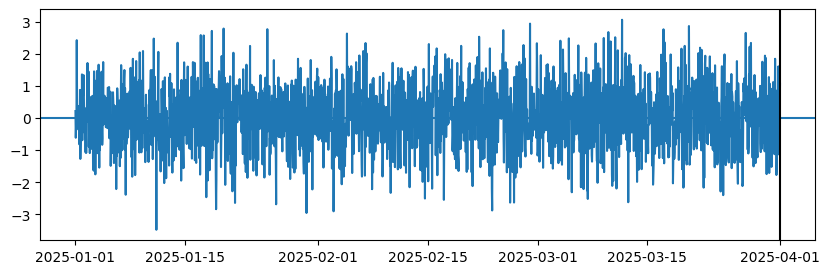

In [21]:
## Simulate a Path of Innovation Shocks
##
rng = np.random.default_rng(seed=337)
innovation_shocks = rng.normal(size=contest_hours)

plt.figure(figsize=(10, 3))
plt.plot(contest_timegrids, innovation_shocks)
yrange = plt.ylim()
xrange = plt.xlim()
plt.hlines(y = 0, xmin=xrange[0], xmax=xrange[1])
plt.vlines(x = end_time, ymin=yrange[0], ymax=yrange[1], colors='black')  # type: ignore
plt.xlim(xrange)
plt.ylim(yrange)
plt.show()

In [ ]:
def calculate_contest_dynamics( \
		time_grids: npt.NDArray[np.datetime64],
		time_unit_float: float,
		innovation_shocks: npt.NDArray[np.float64],
		theta: float,
		c_i: float,
		c_j: float,
		sigma: float,
		lamb: float
):
	"""Calculate the Dynamics of Efforts and Gap
	"""
	dynamic_i_effort = np.zeros_like(time_grids, dtype=np.float64)
	dynamic_j_effort = np.zeros_like(time_grids, dtype=np.float64)
	dynamics_gap = np.zeros(shape = len(time_grids), dtype=np.float64)
	gap_t = 0
	for idx_time, time in enumerate(time_grids):
		q_i, q_j = ryvkin_model.get_equilibrium_efforts(gap_t, time, time_grids[-1],
			prize=theta,
			c_i=c_i,
			c_j=c_j,
			innov_uncert=sigma
		)
		shock = innovation_shocks[idx_time] * sigma * time_unit_float**0.5
		kalman_gain = lamb**0.5 * sigma *
		dynamics_gap[idx_time] = gap_t + (q_i - q_j) * time_unit_float + kalman_gain
		dynamic_i_effort[idx_time] = q_i
		dynamic_j_effort[idx_time] = q_j
		gap_t = dynamics_gap[idx_time]
	return dynamic_i_effort, dynamic_j_effort, dynamics_gap

In [34]:
contest_timegrids

array(['2025-01-01T00:00:00.000000', '2025-01-01T01:00:00.000000',
       '2025-01-01T02:00:00.000000', ..., '2025-03-31T21:00:00.000000',
       '2025-03-31T22:00:00.000000', '2025-03-31T23:00:00.000000'],
      shape=(2160,), dtype='datetime64[us]')

In [36]:
dynamic_i_effort, dynamic_j_effort, dynamics_gap = \
	calculate_contest_dynamics( \
			contest_timegrids,
			1/24,
			innovation_shocks,
			param_theta, param_c_i, param_c_j, param_sigma)

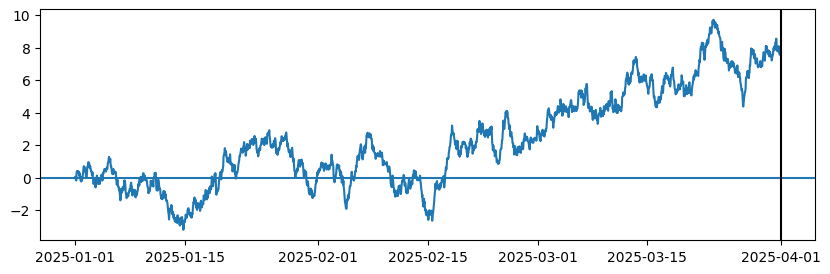

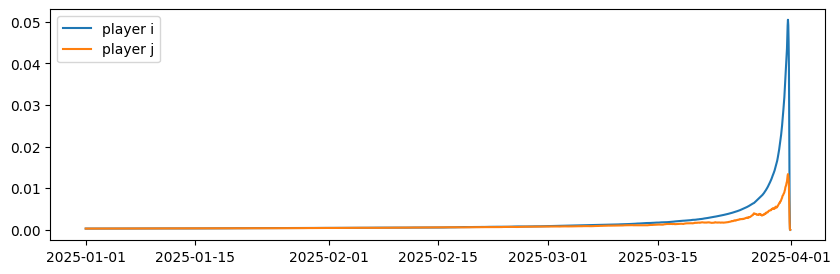

In [37]:
plt.figure(figsize=(10, 3))
plt.plot(contest_timegrids, dynamics_gap)
yrange = plt.ylim()
xrange = plt.xlim()
plt.hlines(y = 0, xmin=xrange[0], xmax=xrange[1])
plt.vlines(x = end_time, ymin=yrange[0], ymax=yrange[1], colors='black')  # type: ignore
plt.xlim(xrange)
plt.ylim(yrange)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(contest_timegrids, dynamic_i_effort, label='player i')
plt.plot(contest_timegrids, dynamic_j_effort, label='player j')
plt.legend()
plt.show()

### 3. Simulate Submission Data

In [38]:
effort_intensity_ratio = 5
seed_poisson = 1234
seed_uniform = 5678

[datetime.datetime(2025, 1, 25, 1, 10, 36, 805305),
 datetime.datetime(2025, 2, 5, 23, 43, 32, 521888),
 datetime.datetime(2025, 2, 22, 7, 25, 43, 848933),
 datetime.datetime(2025, 2, 22, 17, 40, 33, 259909),
 datetime.datetime(2025, 3, 6, 11, 2, 42, 814945),
 datetime.datetime(2025, 3, 23, 11, 54, 21, 469577),
 datetime.datetime(2025, 3, 26, 1, 51, 19, 308643),
 datetime.datetime(2025, 3, 26, 4, 2, 1, 470445),
 datetime.datetime(2025, 3, 26, 14, 13, 1, 680279),
 datetime.datetime(2025, 3, 27, 6, 56, 30, 440251),
 datetime.datetime(2025, 3, 27, 19, 35, 40, 482551),
 datetime.datetime(2025, 3, 28, 5, 17, 42, 362874),
 datetime.datetime(2025, 3, 28, 7, 44, 22, 160553),
 datetime.datetime(2025, 3, 28, 7, 57, 3, 807037),
 datetime.datetime(2025, 3, 28, 14, 43, 38, 686089),
 datetime.datetime(2025, 3, 31, 4, 2, 11, 284844)]


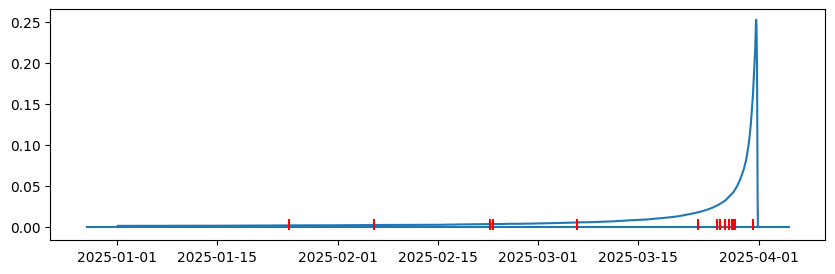

In [39]:
## Player i
##
# Interpolate effort as an intensity function
submission_intensity_i = nhpp.intensity_interp_d( \
		contest_timegrids, dynamic_i_effort, ratio=effort_intensity_ratio)

# Simulate submission data
submit_events_i = nhpp.simulate_inhomogeneous_poisson_process( \
		start_time, end_time, submission_intensity_i, 0.06,
		seed_poisson=seed_poisson, seed_uniform=seed_uniform)
pprint(submit_events_i)

# Visualization
fig, ax = nhpp.plot_intensity( \
		submission_intensity_i, (start_time, end_time), timedelta(hours=1))
ax = nhpp.plot_poisson_events(ax, submit_events_i)

[datetime.datetime(2025, 1, 25, 1, 10, 36, 805305),
 datetime.datetime(2025, 2, 5, 23, 43, 32, 521888),
 datetime.datetime(2025, 2, 22, 7, 25, 43, 848933),
 datetime.datetime(2025, 2, 22, 17, 40, 33, 259909),
 datetime.datetime(2025, 3, 6, 11, 2, 42, 814945),
 datetime.datetime(2025, 3, 26, 1, 51, 19, 308643),
 datetime.datetime(2025, 3, 26, 14, 13, 1, 680279),
 datetime.datetime(2025, 3, 27, 6, 56, 30, 440251),
 datetime.datetime(2025, 3, 27, 19, 35, 40, 482551),
 datetime.datetime(2025, 3, 28, 14, 43, 38, 686089),
 datetime.datetime(2025, 3, 31, 4, 2, 11, 284844)]


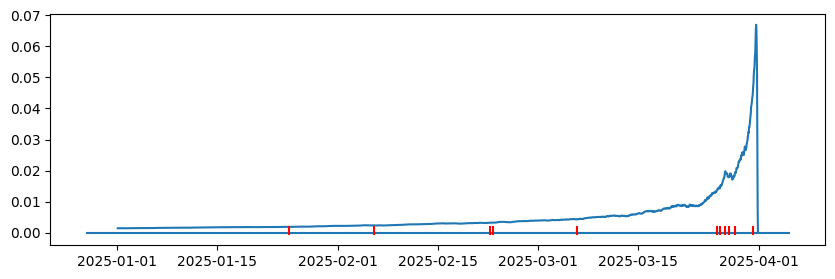

In [40]:
## Player j
##
# Interpolate effort as an intensity function
submission_intensity_j = nhpp.intensity_interp_d( \
		contest_timegrids, dynamic_j_effort, ratio=effort_intensity_ratio)

# Simulate submission data
submit_events_j = nhpp.simulate_inhomogeneous_poisson_process( \
		start_time, end_time, submission_intensity_j, 0.06,
		seed_poisson=seed_poisson, seed_uniform=seed_uniform)
pprint(submit_events_j)

# Visualization
fig, ax = nhpp.plot_intensity( \
		submission_intensity_j, (start_time, end_time), timedelta(hours=1))
ax = nhpp.plot_poisson_events(ax, submit_events_j, vline_width=0.002)

### 4. Bayesian Estimation

In [ ]:
import pymc as pm
import arviz as az

In [ ]:
with pm.Model() as model:
	# Prior
	shocks_sigma = pm.Gamma('shocks_sigma', alpha=1, beta=1)
	c_i = pm.Gamma('c_i', alpha=1, beta=1)
	c_j = pm.Gamma('c_j', alpha=1, beta=1)

	# Shocks
	shocks = pm.GaussianRandomWalk('shocks',
			mu=0,
			sigma=shocks_sigma, \
			steps=1000,
			init_dist=pm.Normal.dist(mu=0, sigma=1)
	)

	# Calculate the intensity function


	trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [shocks]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [65]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
shocks[0],0.000,0.000,-0.000,0.000,0.000,0.000,3764.0,2825.0,1.00
shocks[1],0.017,1.024,-1.851,2.017,0.016,0.013,3915.0,2949.0,1.00
shocks[2],0.042,1.445,-2.646,2.773,0.024,0.018,3695.0,3291.0,1.00
shocks[3],0.058,1.755,-3.111,3.461,0.032,0.022,3035.0,3499.0,1.00
shocks[4],0.106,2.024,-3.732,3.900,0.038,0.027,2798.0,3019.0,1.00
...,...,...,...,...,...,...,...,...,...
shocks[996],2.570,31.607,-54.816,63.876,6.386,2.168,24.0,105.0,1.12
shocks[997],2.559,31.627,-54.970,64.129,6.391,2.167,24.0,105.0,1.12
shocks[998],2.563,31.637,-55.432,63.648,6.396,2.166,24.0,105.0,1.12
shocks[999],2.557,31.667,-54.524,64.736,6.398,2.166,24.0,103.0,1.12
